In [1]:


%matplotlib notebook
import scipy
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from matplotlib           import cm
from scipy.stats          import norm
from scipy.optimize       import brentq
from mpl_toolkits.mplot3d import axes3d

plt.style.use('seaborn')
pd.options.mode.chained_assignment = None

def N(z):
    return norm.cdf(z)

def black_scholes_call_value(S, K, r, t, vol):
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    return N(d1) * S - N(d2) * K * np.exp(-r * t)

def black_scholes_put_value(S, K, r, t, vol):
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    return N(-d2) * K * np.exp(-r * t) - N(-d1) * S

def call_implied_volatility_objective_function(S, K, r, t, vol, call_option_market_price):
    return call_option_market_price - black_scholes_call_value(S, K, r, t, vol)

def call_implied_volatility(S, K, r, t, call_option_market_price, a=-2.0, b=2.0, xtol=1e-6):
    _S, _K, _r, _t, _call_option_market_price = S, K, r, t, call_option_market_price
    def fcn(vol):
        return call_implied_volatility_objective_function(_S, _K, _r, _t, vol, _call_option_market_price)
    try:
        result = brentq(fcn, a=a, b=b, xtol=xtol)
        return 0 if result <= 1.0e-6 or call_option_market_price == 0 else result
    except ValueError:
        return 0

def put_implied_volatility_objective_function(S, K, r, t, vol, put_option_market_price):
    return put_option_market_price - black_scholes_put_value(S, K, r, t, vol)

def put_implied_volatility(S, K, r, t, put_option_market_price, a=-2.0, b=2.0, xtol=1e-6):
    _S, _K, _r, _t, _put_option_market_price = S, K, r, t, put_option_market_price
    def fcn(vol):
        return put_implied_volatility_objective_function(_S, _K, _r, _t, vol, _put_option_market_price)
    try:
        result = brentq(fcn, a=a, b=b, xtol=xtol)
        return 0 if result <= 1.0e-6 or put_option_market_price == 0 else result
    except ValueError:
        return 0

def call_implied_vol_mid(series):
    S = series['Spot']
    K = series['Strike']
    r = series['Rf']
    t = series['Expiration']
    l = series['CallMid']
    return float(globals().get('call_implied_volatility')(S, K, r, t, l))

def put_implied_vol_mid(series):
    S = series['Spot']
    K = series['Strike']
    r = series['Rf']
    t = series['Expiration']
    l = series['PutMid']
    return float(globals().get('put_implied_volatility')(S, K, r, t, l))

db = pd.read_hdf("optiondata.h5")
db = db.drop('index',axis=1)
db['Now'] = pd.to_datetime(db['Now'])
db['Maturity'] = pd.to_datetime(db['Maturity'])
db[15:20]

,CallAsk,CallBid,CallLast,CallOI,CallVolume,PutAsk,PutBid,PutLast,PutOI,PutVolume,Rf,Spot,Strike,Maturity,Now,Expiration,CallMid,PutMid,CallImpVol,PutImpVol
15,87.7,83.7,80.5,358.0,3.0,53.9,52.0,56.5,486.0,244.0,0,5342.2,5250.0,2018-05-18 17:30:00,2018-04-17 14:30:00,0.085274,85.70,52.95,0.000000,0.148765
16,58.3,55.0,53.6,325.0,38.0,76.6,72.8,75.2,176.0,106.0,0,5342.2,5300.0,2018-05-18 17:30:00,2018-04-17 14:30:00,0.085274,56.65,74.70,0.050173,0.152137
17,35.9,33.2,35.1,719.0,52.0,104.8,100.3,108.4,44.0,5.0,0,5342.2,5350.0,2018-05-18 17:30:00,2018-04-17 14:30:00,0.085274,34.55,102.55,0.061534,0.158330
18,20.6,18.4,19.5,382.0,11.0,0.0,0.0,148.5,64.0,1.0,0,5342.2,5400.0,2018-05-18 17:30:00,2018-04-17 14:30:00,0.085274,19.50,148.50,0.067541,0.187555
19,10.6,9.6,9.8,423.0,7.0,0.0,0.0,0.0,11.0,0.0,0,5342.2,5450.0,2018-05-18 17:30:00,2018-04-17 14:30:00,0.085274,10.10,0.00,0.071290,0.000000


In [2]:
# Let's forget the already calculated implied volatility
db = db.drop('CallImpVol',axis=1)
db = db.drop('PutImpVol',axis=1)
# And now recalculate it, this is just a few minutes of market data
# Imagine what is like working with several months of data
db['CallImpVol'] = db.apply(call_implied_vol_mid, axis=1)
db['PutImpVol'] = db.apply(put_implied_vol_mid, axis=1)

In [3]:
# Selecting closest maturity and cleaning data
M0 = db[db['Maturity'] == '2018-05-18 17:30:00']
M0[M0['CallImpVol'] < 0.001] = 0
M0[M0['PutImpVol'] < 0.001] = 0
M0 = M0.loc[(M0!=0).any(1)]
M0 = M0.reset_index().drop('index',axis=1)
M0['Moneyness'] = abs(M0['Strike']/M0['Spot'])

<IPython.core.display.Javascript object>


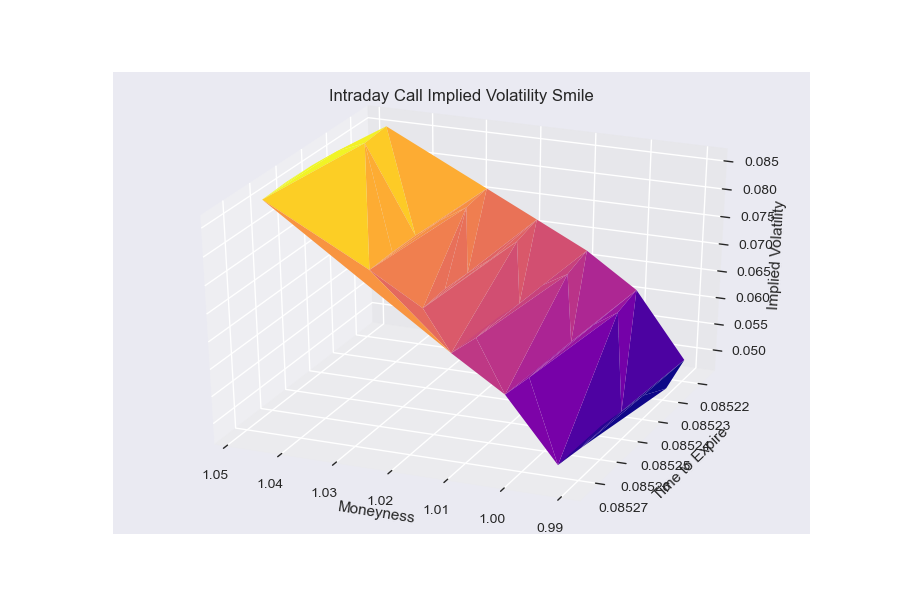

In [4]:
fig = plt.figure(figsize=(9,6))
ax  = fig.gca(projection='3d')
ax.plot_trisurf(M0['Moneyness'], M0['Expiration'], M0['CallImpVol'], cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Expire')
ax.set_zlabel('Implied Volatility')

ax.dist=12
ax.view_init(30, 112.5)
plt.title('Intraday Call Implied Volatility Smile')
plt.show()

<IPython.core.display.Javascript object>


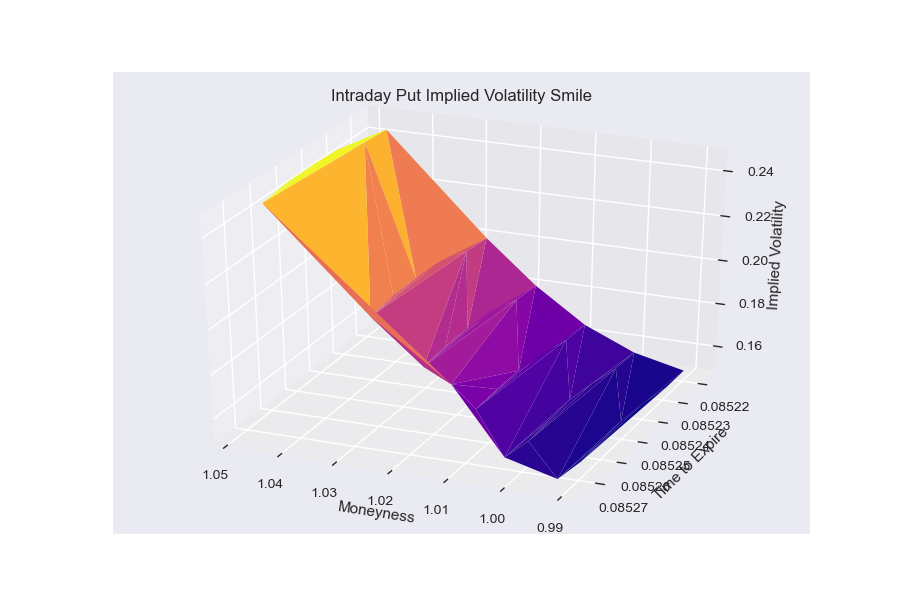

In [5]:
fig = plt.figure(figsize=(9,6))
ax  = fig.gca(projection='3d')
ax.plot_trisurf(M0['Moneyness'], M0['Expiration'], M0['PutImpVol'], cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Expire')
ax.set_zlabel('Implied Volatility')

ax.dist=12
ax.view_init(30, 112.5)
plt.title('Intraday Put Implied Volatility Smile')
plt.show()

In [6]:
# Everything looks good despite being a short sample of real market data
# Now lets take a peak at all maturities at a given moment
Snapshot = db[db['Now'] == '2018-04-17 14:30:00']
Snapshot[Snapshot['CallImpVol'] < 0.001] = 0
Snapshot = Snapshot.loc[(Snapshot!=0).any(1)]
Snapshot = Snapshot.reset_index().drop('index',axis=1)
Snapshot['Moneyness'] = abs(Snapshot['Strike']/Snapshot['Spot'])

<IPython.core.display.Javascript object>


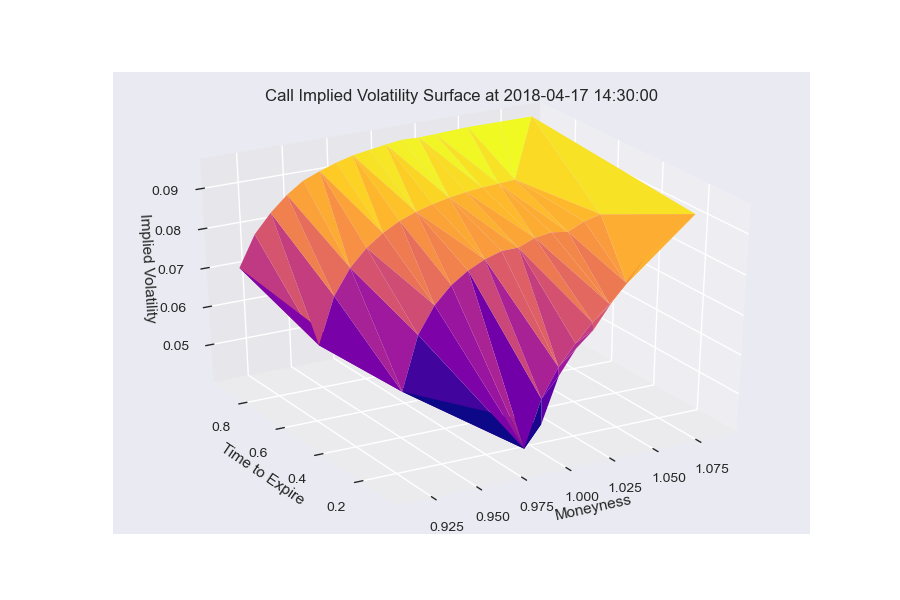

In [7]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(Snapshot['Moneyness'], Snapshot['Expiration'], Snapshot['CallImpVol'],cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Expire')
ax.set_zlabel('Implied Volatility')

ax.dist=12
ax.view_init(30, 240)
plt.title('Call Implied Volatility Surface at 2018-04-17 14:30:00')
plt.show()

In [8]:
# And now for the puts
Snapshot = db[db['Now'] == '2018-04-17 14:30:00']
Snapshot[Snapshot['PutImpVol'] < 0.001] = 0
Snapshot = Snapshot.loc[(Snapshot!=0).any(1)]
Snapshot = Snapshot.reset_index().drop('index',axis=1)
Snapshot['Moneyness'] = abs(Snapshot['Strike']/Snapshot['Spot'])

<IPython.core.display.Javascript object>


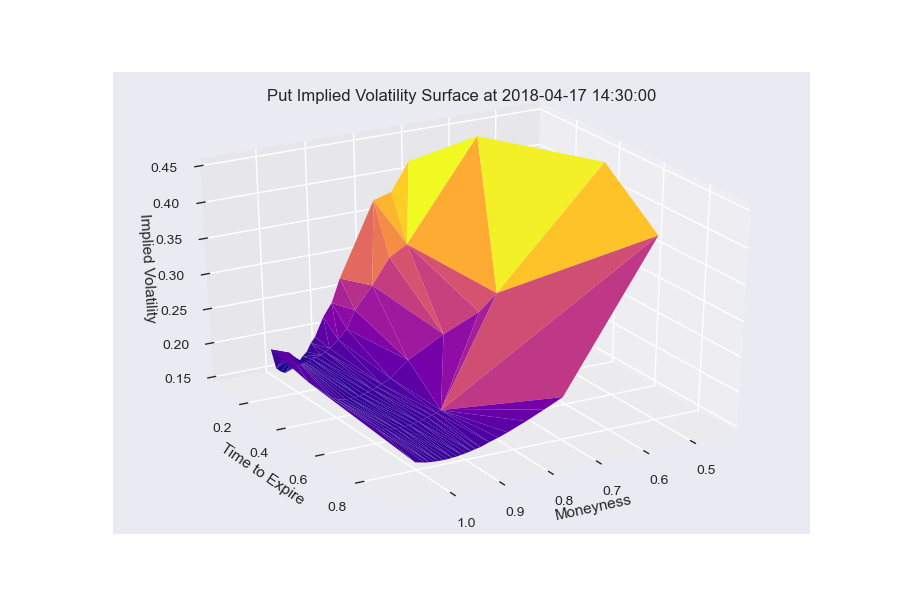

In [9]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(Snapshot['Moneyness'], Snapshot['Expiration'], Snapshot['PutImpVol'],cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Expire')
ax.set_zlabel('Implied Volatility')

ax.dist=12
ax.view_init(30, 60)
plt.title('Put Implied Volatility Surface at 2018-04-17 14:30:00')
plt.show()

So what's the purpose of visualizing all this data?

To understand what we are attempting to do, implied volatility modelling
consists in attempting to describing the behaviour of the implied volatility surface (or just the volatility smile of a given maturity) throughout time with the smallest prediction error possible (or at least in a way doesn't make us lose money)